# Uni- and multivariate time series modeling with seasonal ARIMA and Facebook Prophet for PM10 level in Cracow, Poland

In a notebook I work with a PM10 measurement data sampled every day from January 2001 to December 2018, at different monitoring points in Cracow, Poland. First part is univariate time series analysis and forecast, where I try to predict PM10 level as a function of time alone. In a second part I decided to improve prediction power, introducing external regressors coming from historical weather data. All data is open source, however it's not structured and easily available, so I had to figure out the way to get it. Follow along to see the pipeline and what can be said about smog in Cracow. 

In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import itertools

from io import BytesIO
from zipfile import ZipFile
import requests
import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

# Getting PM10 data

Air quality data comes from http://powietrze.gios.gov.pl/pjp/archives. Unfortunetaly, there is no dedicated API for filtering out and downloading it easily in bulk. For this reason, I downloaded zip files for given year and placed them in working directory. To extract, load and transform PM10 data into python DataFrame, I defined short function below.


In [2]:
# make sure the pwd contains zip files  
def get_data():
    """
    Read, extract and transform PM10 data stored in seperate zipped excel files and return merged dataframe.
    
    """
    pm10=pd.DataFrame() #empty DataFrame
    for year in range(2001,2019):
        zf=ZipFile(str(year)+'.zip') # get zip file from currect directory for given year
        excel_name=str(year)+'_PM10_24g.xlsx' # get file_name
        data=pd.read_excel(zf.open(excel_name),index_col=0) # open excel file
        cols=[x for x in data.columns if 'mpkrak' in x.lower()] # get stations in Cracow (they all start with 'mpkrak')
        data=data.iloc[2:][cols]
        pm10=pd.concat([data,pm10]) # concatenate exisiting DF with new one (add additional data)
        
    pm10.replace(',','.',regex=True, inplace = True) # replace ',' with '.'
    pm10.index=pd.to_datetime(pm10.index) # set datetime index
    pm10=pm10.astype(float) # transform object to float
    pm10.index.name='Time'
    return pm10

In [3]:
# getting data from excel files
pm10=get_data()
pm10.head(4)

,MpKrakBujaka,MpKrakBulwar,MpKrakOsPias,MpKrakTelime,MpKrakWadow,MpKrakZloRog,MpKrakowWIOSAKra6117,MpKrakowWIOSBuja6119,MpKrakowWIOSBulw6118,MpKrakowWIOSPrad6115,MpKrakowWSSEPrad6102,MpKrakowWSSERPod6113
Time,,,,,,,,,,,,
2018-01-01,NaN,65.79,53.70,NaN,28.74,67.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,NaN,75.57,59.69,NaN,48.78,78.60,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,NaN,22.84,20.75,NaN,18.78,25.70,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,20.58,23.97,19.13,13.39,19.51,22.86,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
pm10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 2018-01-01 to 2001-12-31
Data columns (total 12 columns):
MpKrakBujaka            1418 non-null float64
MpKrakBulwar            1386 non-null float64
MpKrakOsPias            1075 non-null float64
MpKrakTelime            503 non-null float64
MpKrakWadow             660 non-null float64
MpKrakZloRog            1088 non-null float64
MpKrakowWIOSAKra6117    3293 non-null float64
MpKrakowWIOSBuja6119    1655 non-null float64
MpKrakowWIOSBulw6118    2122 non-null float64
MpKrakowWIOSPrad6115    2341 non-null float64
MpKrakowWSSEPrad6102    116 non-null float64
MpKrakowWSSERPod6113    151 non-null float64
dtypes: float64(12)
memory usage: 667.7 KB


# Exploratory Data Anaysis and Feature Engineering

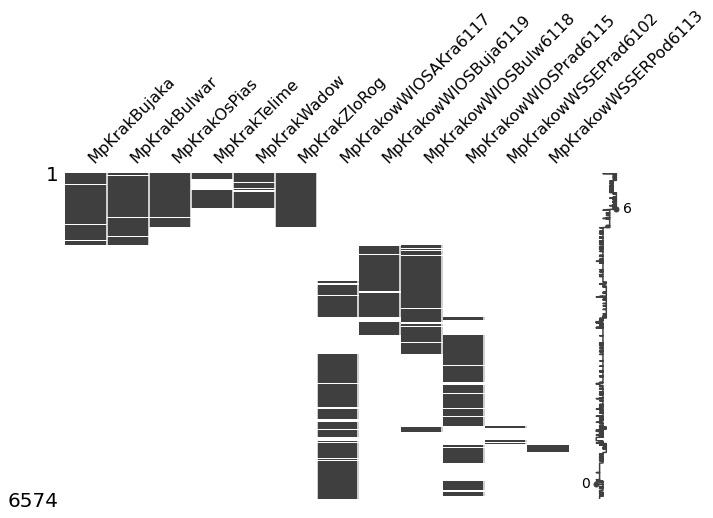

In [5]:
# plot missing values 
msno.matrix(pm10,figsize=(10, 6));

Because there are no stations without periods of missing values, I decided to calculate mean PM10 level of all stations in Cracow and use it for further analysis and modeling.

In [6]:
# calculate mean PM10 from all stations and fill NA
pm10['MeanPM10']=pm10.mean(axis=1)
pm10['MeanPM10']=pm10['MeanPM10'].fillna(pm10['MeanPM10'].bfill())
# create new columns with year, month and weekdays
pm10['Year']=pm10.index.year
pm10['Month']=pm10.index.month
pm10['Weekday']=pm10.index.weekday_name

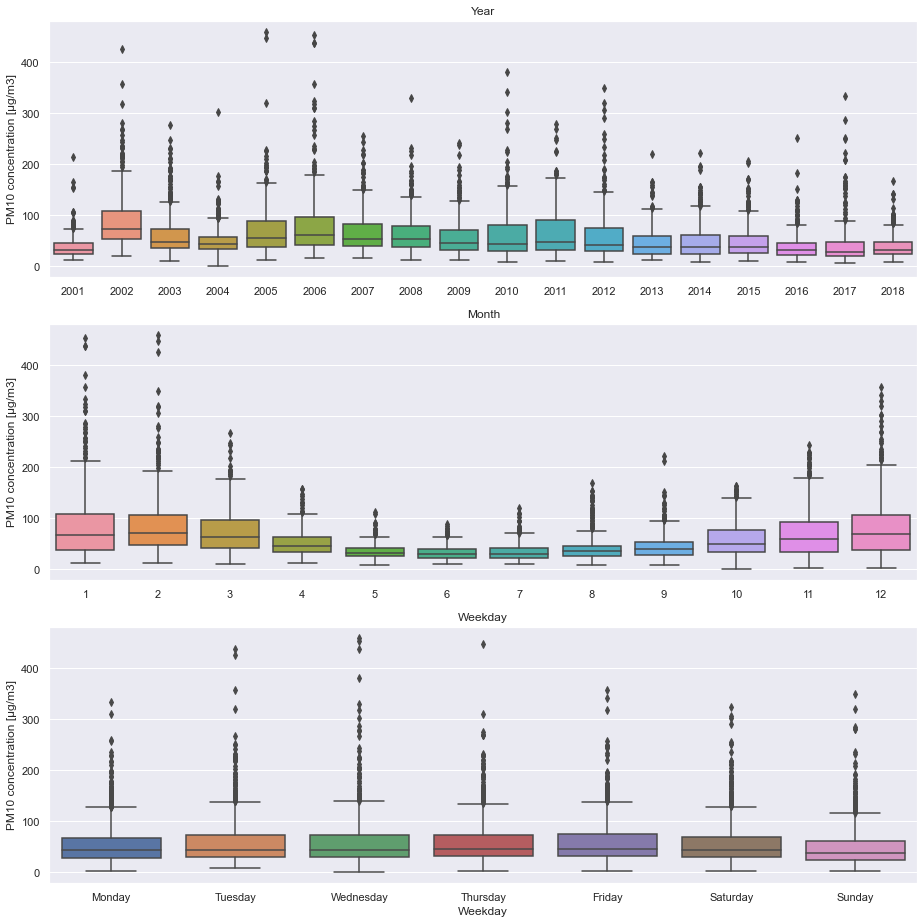

In [7]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.set()

# Box plots for different time periods
cols=['Year','Month','Weekday']
fig,axes=plt.subplots(3,1,figsize=(13,13))
for col, ax in zip(cols,axes):
    sns.boxplot(y='MeanPM10',x=col,data=pm10,ax=ax)
    ax.set_title(col)
    ax.set_ylabel('PM10 concentration [µg/m3]')
    if ax!= axes[-1]:
        ax.set_xlabel('')
plt.tight_layout()

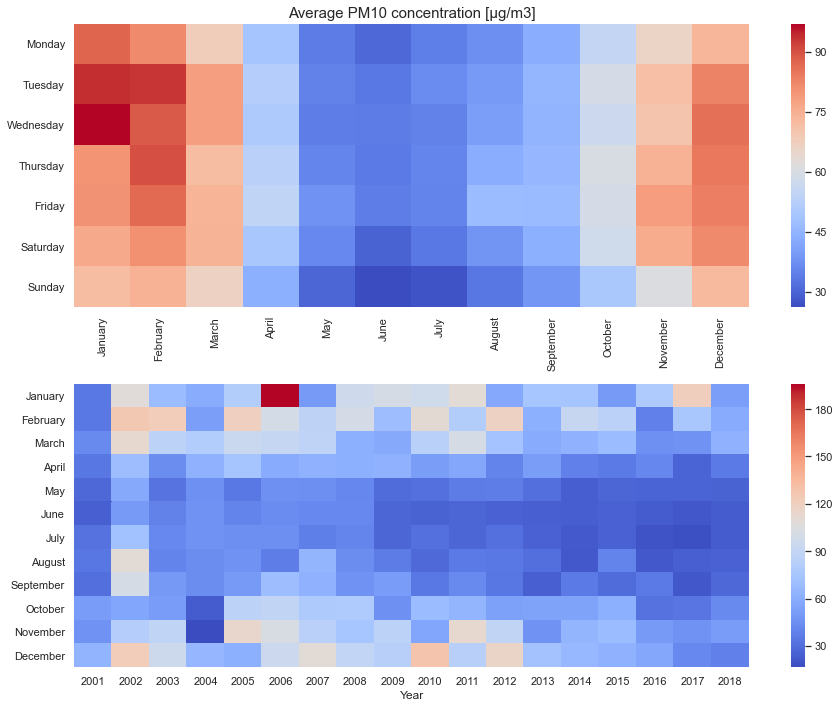

In [8]:
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
months=['January','February','March','April','May','June','July','August','September','October','November','December']

# Get heatmaps for two pivot tables:
fig,axes=plt.subplots(2,1,figsize=(13,10))
pivot=pd.pivot_table(data=pm10,values='MeanPM10',index=pm10.index.weekday,columns='Month')
pivot.index=weekdays 
pivot.columns=months
sns.heatmap(pivot,cmap='coolwarm',ax=axes[0])
axes[0].set_title('Average PM10 concentration [µg/m3]',fontsize=15)

pivot=pd.pivot_table(data=pm10,values='MeanPM10',index='Month',columns='Year')
pivot.index=months
sns.heatmap(pivot,cmap='coolwarm',ax=axes[1])

plt.tight_layout()

## A few observations:

* Not surprisingly- the lowest PM10 level is observed during summers, the highest - during winters
* Both average PM10 and variance do decrease over last years
* Within all analysed time periods, there are strong positive outliers present, especially during winter months, what is most likely connected with weather conditions/increased traffic
* The least PM10-polluted day is Sunday and the best time to go out for a walk is June 
* You better stay home on Wednesdays and Tuesdays in January

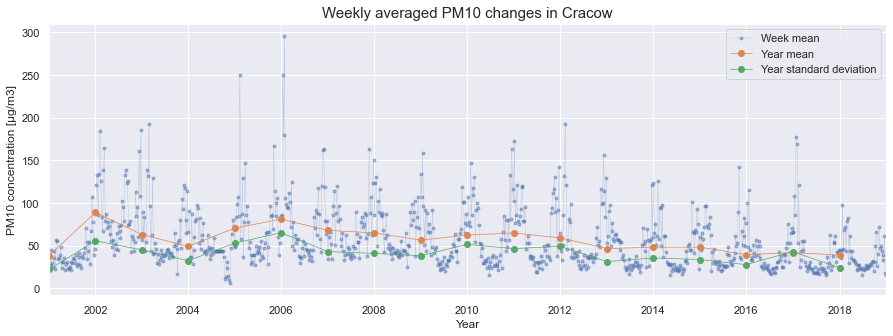

In [9]:
start='2000'
end='2019'
pm10_year=pm10.resample('Y').mean()
pm10_year_std=pm10.resample('Y').std()
pm10_week=pm10.resample('W').mean()

fig,ax=plt.subplots()

pm10_week.loc[start:end,'MeanPM10'].plot(marker='.',linewidth=0.3,ax=ax,alpha=0.45,label='Week mean')
pm10_year.loc[start:end,'MeanPM10'].plot(marker='o',linewidth=0.7,ax=ax,label='Year mean')
pm10_year_std.loc[start:end,'MeanPM10'].plot(marker='o',linewidth=0.7,ax=ax,label='Year standard deviation')

plt.title('Weekly averaged PM10 changes in Cracow',fontsize=15)
plt.ylabel('PM10 concentration [µg/m3]')
plt.xlabel('Year')
plt.legend()

There is a gradual, constant drop of PM10 level since 2006 with visible downward trend, for both mean and variance, aslo outliers seem to be less extreme. To make data more stationary, let's calculate log(PM10).

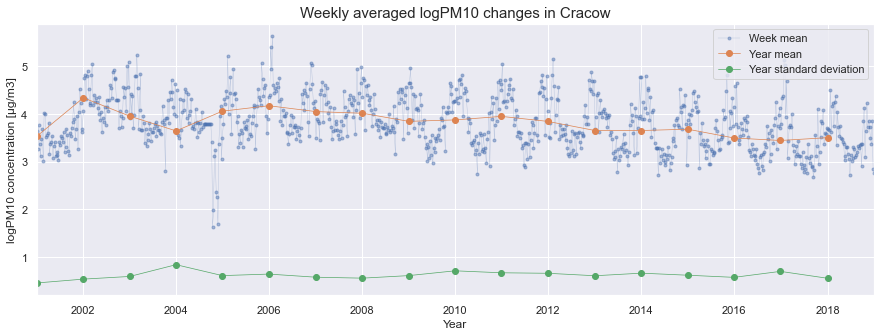

In [10]:
start='2000'
end='2019'
pm10log=pm10.iloc[:,:13].apply(lambda x:np.log(x))
pm10_year=pm10log.resample('Y').mean()
pm10_year_std=pm10log.resample('Y').std()
pm10_week=pm10log.resample('W').mean()

fig,ax=plt.subplots()

pm10_week.loc[start:end,'MeanPM10'].plot(marker='.',linewidth=0.3,ax=ax,alpha=0.45,label='Week mean')
pm10_year.loc[start:end,'MeanPM10'].plot(marker='o',linewidth=0.7,ax=ax,label='Year mean')
pm10_year_std.loc[start:end,'MeanPM10'].plot(marker='o',linewidth=0.7,ax=ax,label='Year standard deviation')

plt.title('Weekly averaged logPM10 changes in Cracow',fontsize=15)
plt.ylabel('logPM10 concentration [µg/m3]')
plt.xlabel('Year')
plt.legend()

To see seasonality, trend and random residual values, we can use the decomposition method. Remaining residual variability is the data after removing the effects of the seasonality and trend.

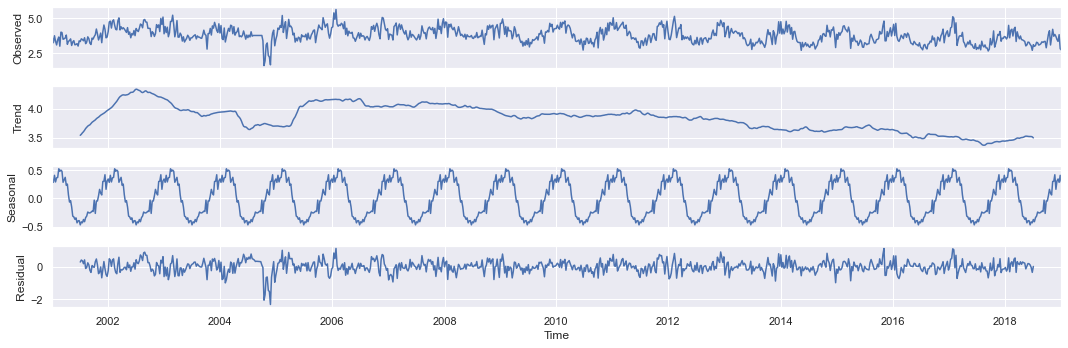

In [11]:
# use log(PM10) calculated in previous step
y=pm10_week['MeanPM10'].copy()

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot shows that the data has both trend and seasonality, what implies that data is not stationary. It violates assumption of ARIMA model I am going to use, hence I will have to make data stationary in next steps.

# Univariate time series modelling

# Seasonal ARIMA model

ARIMA model is one of the most common methods used in time series forecasting. It stands for AutoregRessive Integrated Moving Average. There are three integers (p, d, q) which are used to parametrize ARIMA models and another three integers (P, D, Q) applied to the seasonal component of the time series.

* p/P is the auto-regressive part of the model (AR). It allows to incorporate the effect of past values into model.

* d/D is the integrated part of the model (I). This is the amount of differencing to apply to the time series (one of the ways to deal with non-stationarity).

* q/Q is the moving average part of the model (MA). It sets the error of model as a linear combination of the error values observed at previous time points in the past.

There are two usefull plots to determine ARIMA's params:

* ACF is an (complete) auto-correlation function which gives values of auto-correlation of any series with its lagged values.
* PACF is a partial auto-correlation function and instead of finding correlations of present with lags like ACF, it finds correlation of the residuals.

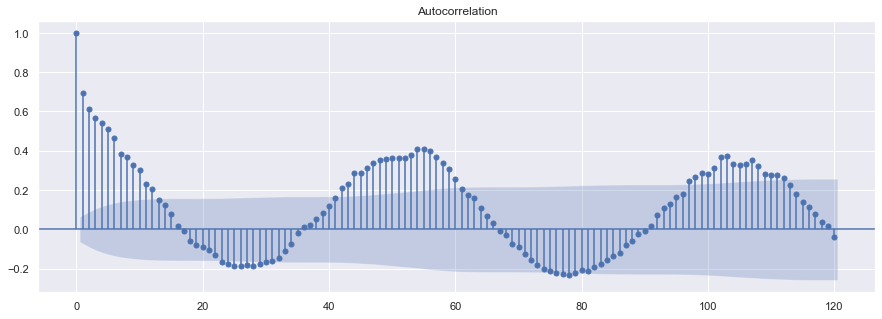

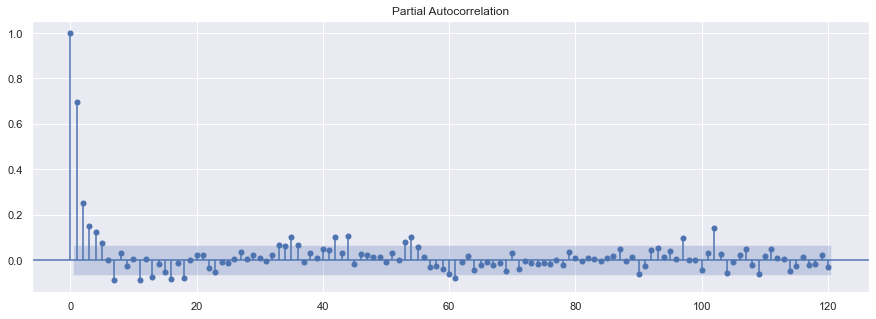

In [12]:
acf=plot_acf(y,lags=120)
pacf=plot_pacf(y,lags=120)

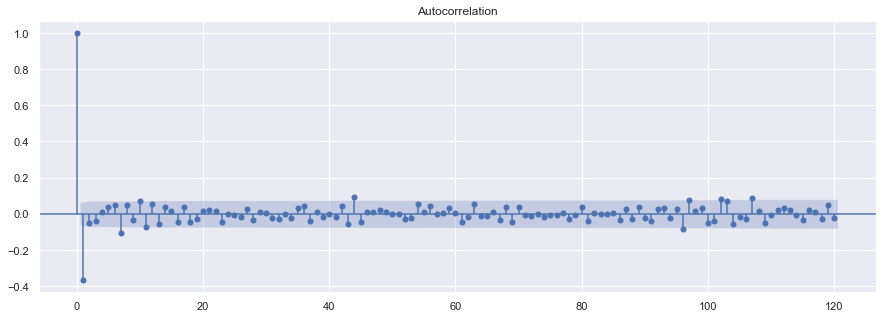

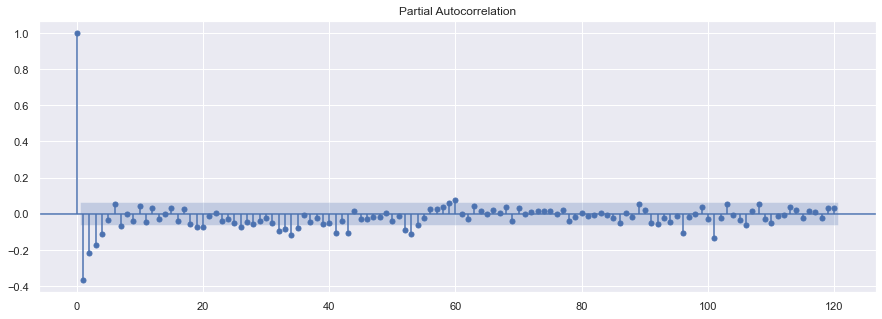

In [13]:
# let's apply first order differencing

y_diffs=y.diff(periods=1).dropna()
acf=plot_acf(y_diffs,lags=120)
pacf=plot_pacf(y_diffs,lags=120)

To confirm non-stationarity of data, I will use the Dickey-Fuller Hypothesis testing, where:
* Null Hypothesis: The series is not stationary.
* Alternative Hypothesis: The series is stationary.

In [14]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(y_diffs)
print('ADF Statistic:{:.3f}'.format(test_result[0]))
print('p-value:{:.3f}'.format(test_result[1]))
print('Critical Values:')
for key, value in test_result[4].items():
    print('{}:{:.3f}'.format(key, value))

ADF Statistic:-14.379
p-value:0.000
Critical Values:
1%:-3.437
5%:-2.865
10%:-2.568


With the p-value <<0.05, I rejected the null hypothesis. Taking into account PACF and ACF plots and differencing, one can assume (p,d,q) to be (4,1,1). However different sets of (p,d,q) and (P,D,Q) should be also tested.

In [15]:
# ARIMA parameters 
p=range(4,5)
q=d=range(1,3)
pdq = list(itertools.product(p, d, q))

# seasonal ARIMA parameters 
P=D=Q=range(0,2)
PDQ = list(itertools.product(P,D,Q))
seasonal_pdq =[(x[0],x[1],x[2],52) for x in list(itertools.product(P,D,Q))] # 52 is the average number of weeks in a year, since data shows seasonality

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (4, 1, 2) x (0, 0, 1, 52)
SARIMAX: (4, 1, 2) x (0, 1, 0, 52)
SARIMAX: (4, 2, 1) x (0, 1, 1, 52)
SARIMAX: (4, 2, 1) x (1, 0, 0, 52)


In [16]:
def grid_search(y,pdq,seasonal_pdq):
    """
    Search for best model over range of combinations of seasonal ARIMA parameters.
    ---------------
    parameters:
    y : time series with datetime index
    pdq : ARIMA params
    seasonal_pdq : params of seasonal part of ARIMA
    ---------------
    return: parameters of model with lowest Akaike Information Critera (AIC) score
    
    """

    best_score=np.PINF
    best_model=None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit()
            
                if best_score>results.aic:
                    best_score=results.aic
                    best_model='ARIMA{}x{}'.format(param, param_seasonal)

                print('ARIMA{}x{} - AIC:{:.1f}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('--'*30)
    print('Best model: {}, AIC {:.1f}'.format(best_model,best_score))

In [17]:
# divide into train and test set, set test is 6-month forecast
y_train=y.loc['2001':'2018-6']
y_test=y.loc['2018-7':'2018-12-30']

In [18]:
# run grid search over params
grid_search(y_train,pdq,seasonal_pdq)

ARIMA(4, 1, 1)x(0, 0, 0, 52) - AIC:796.3
ARIMA(4, 1, 1)x(0, 0, 1, 52) - AIC:764.3
ARIMA(4, 1, 1)x(0, 1, 0, 52) - AIC:1320.8
ARIMA(4, 1, 1)x(0, 1, 1, 52) - AIC:746.8
ARIMA(4, 1, 1)x(1, 0, 0, 52) - AIC:762.6
ARIMA(4, 1, 1)x(1, 0, 1, 52) - AIC:764.4
ARIMA(4, 1, 1)x(1, 1, 0, 52) - AIC:995.3
ARIMA(4, 1, 1)x(1, 1, 1, 52) - AIC:764.4
ARIMA(4, 1, 2)x(0, 0, 0, 52) - AIC:799.8
ARIMA(4, 1, 2)x(0, 0, 1, 52) - AIC:765.5


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 2)x(0, 1, 0, 52) - AIC:1316.3


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 2)x(0, 1, 1, 52) - AIC:739.1
ARIMA(4, 1, 2)x(1, 0, 0, 52) - AIC:761.7
ARIMA(4, 1, 2)x(1, 0, 1, 52) - AIC:763.3
ARIMA(4, 1, 2)x(1, 1, 0, 52) - AIC:993.5


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 2)x(1, 1, 1, 52) - AIC:762.7
ARIMA(4, 2, 1)x(0, 0, 0, 52) - AIC:803.7
ARIMA(4, 2, 1)x(0, 0, 1, 52) - AIC:772.6
ARIMA(4, 2, 1)x(0, 1, 0, 52) - AIC:1381.3
ARIMA(4, 2, 1)x(0, 1, 1, 52) - AIC:797.4
ARIMA(4, 2, 1)x(1, 0, 0, 52) - AIC:769.9
ARIMA(4, 2, 1)x(1, 0, 1, 52) - AIC:771.5
ARIMA(4, 2, 1)x(1, 1, 0, 52) - AIC:1056.1
ARIMA(4, 2, 1)x(1, 1, 1, 52) - AIC:821.0
ARIMA(4, 2, 2)x(0, 0, 0, 52) - AIC:805.5
ARIMA(4, 2, 2)x(0, 0, 1, 52) - AIC:771.5


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(0, 1, 0, 52) - AIC:1331.3


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(0, 1, 1, 52) - AIC:757.9


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(1, 0, 0, 52) - AIC:771.7


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(1, 0, 1, 52) - AIC:773.2


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(1, 1, 0, 52) - AIC:1011.7


C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 2, 2)x(1, 1, 1, 52) - AIC:792.5
------------------------------------------------------------
Best model: ARIMA(4, 1, 2)x(0, 1, 1, 52), AIC 739.1


In [19]:
# divide into train and test set, set test is 6-month forecast
y_train=y.loc['2001':'2018-6']
y_test=y.loc['2018-7':'2018-12-30']

# make model with best set of params
sarima = sm.tsa.statespace.SARIMAX(y_train,
                                            order=(4,1,2),
                                            seasonal_order=(0, 1, 1,52),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = sarima.fit()

C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


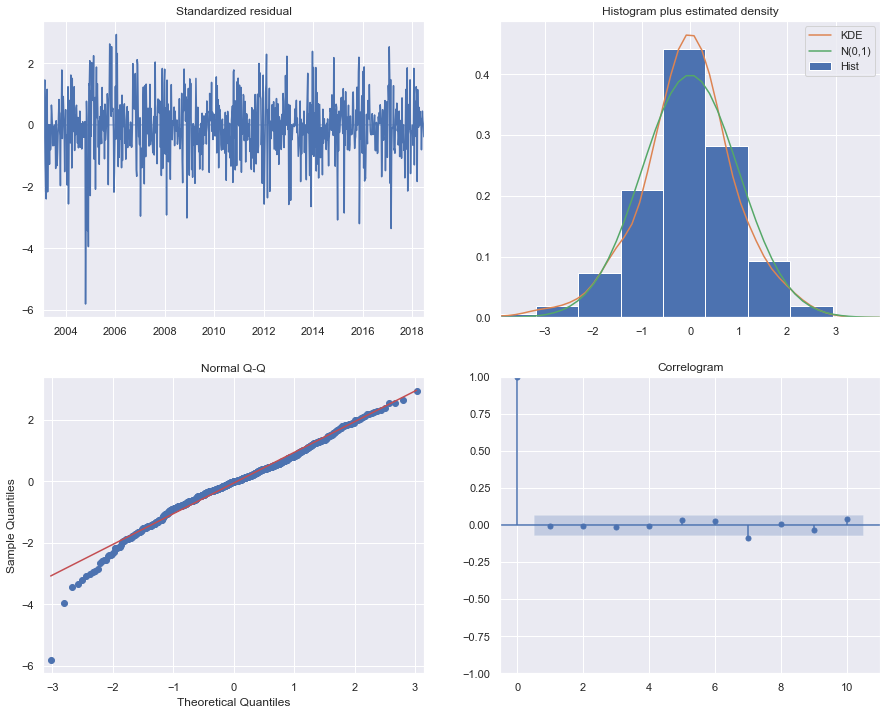

In [20]:
# run diagnostics to check for unusual behaviour
results.plot_diagnostics(figsize=(15, 12))
plt.show()

The residuals are uncorrelated and normally distributed with zero-mean, what indicates good quality of the model (it can't be significantly imporved further).

In [21]:
# get predicted values for trained data and confidence interval
pred = results.get_prediction(start=pd.to_datetime('2010-01-03'), dynamic=False)
pred_ci = pred.conf_int()

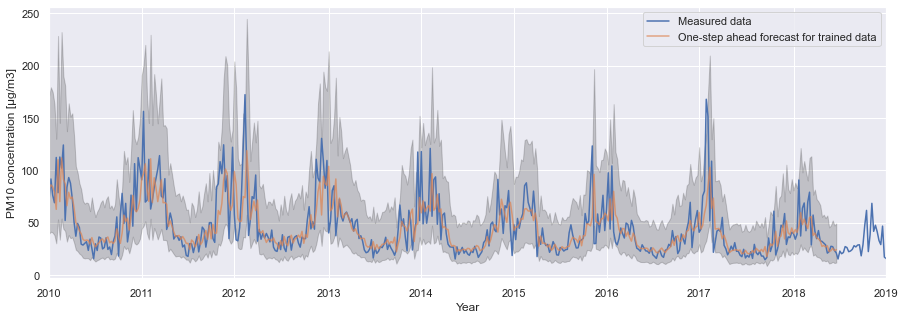

In [22]:
plt.figure(figsize=(15,5))
ax = np.exp(y.loc['2010-01-03':]).plot(label='Measured data')
np.exp(pred.predicted_mean).plot(ax=ax, label='One-step ahead forecast for trained data', alpha=.7)

ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('PM10 concentration [µg/m3]')
plt.legend()

plt.show()

In [23]:
# get forecast 2 years ahead in future
pred_uc = results.get_forecast(steps=80)

# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

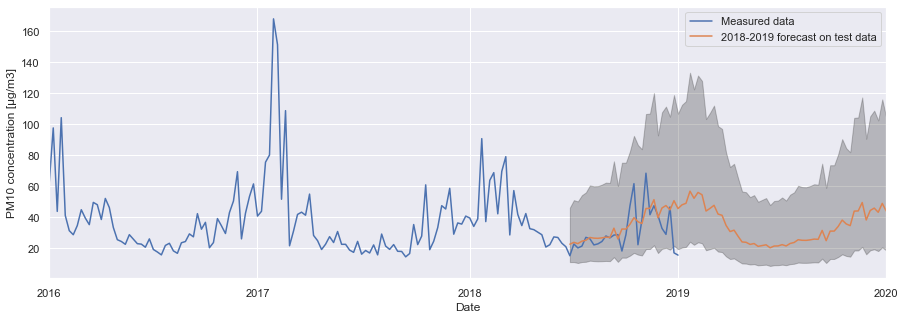

In [24]:
ax = np.exp(y.loc['2016':]).plot(label='Measured data')
np.exp(pred_uc.predicted_mean).plot(ax=ax, label='2018-2019 forecast on test data')
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PM10 concentration [µg/m3]')

plt.legend()
plt.show()

Calculate RMSE for test 2018 data, which was not used to build ARIMA model.

In [25]:
from sklearn.metrics import mean_squared_error
y_hat=pred_uc.predicted_mean.loc[:'2018-12-30']
print('Univariate SARIMA RMSE is {:.2f}'.format(mean_squared_error(np.exp(y_test),np.exp(y_hat),squared=False)))

Univariate SARIMA RMSE is 11.24


# Facebook Prophet model

Prophet is forecasting tool released by Facebook in 2017, designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It much more automated and doesn't involve extensive hyperparameters tuning as compared with ARIMA.

In [26]:
from fbprophet import Prophet

In [27]:
# transform data into format that fbprophet accepts
fb_pm10=y['2001':'2018-6'].reset_index().rename(columns={'Time': 'ds', 'MeanPM10': 'y'})

In [28]:
# create model and fit it 
fb_model = Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True)
fb_model.fit(fb_pm10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
# get forecast 80 weeks ahead in future
future_dates = fb_model.make_future_dataframe(periods=80, freq='W')
forecast = fb_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
987,2019-12-08,3.725834,2.969382,4.545808
988,2019-12-15,3.716735,2.943507,4.526508
989,2019-12-22,3.668683,2.849821,4.468310
990,2019-12-29,3.634389,2.816836,4.358708
991,2020-01-05,3.644814,2.846178,4.420207


<Figure size 1080x360 with 0 Axes>

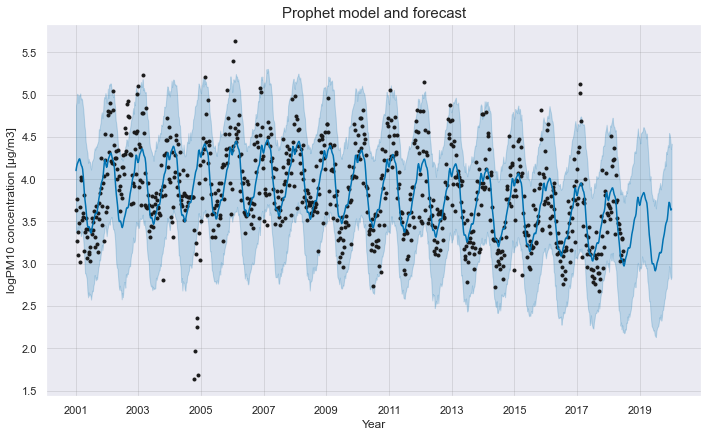

In [30]:
plt.figure()
fb_model.plot(forecast, xlabel = 'Year', ylabel = 'logPM10 concentration [µg/m3]')
plt.title('Prophet model and forecast',fontsize=15);

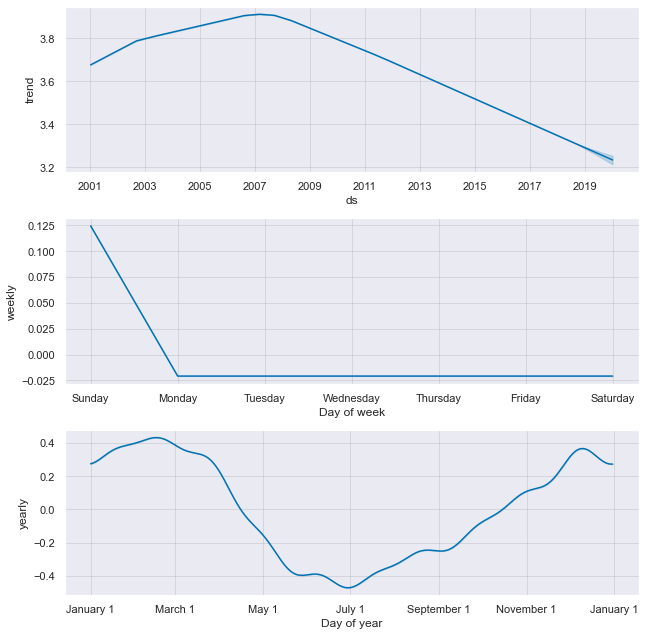

In [31]:
# get model's components
fb_model.plot_components(forecast);

In [32]:
# let's check RMSE for test set
y_hat_fb=forecast.loc[912:938]['yhat']
print('Univariate Prophet RMSE is {:.2f}'.format(mean_squared_error(np.exp(y_test),np.exp(y_hat_fb),squared=False)))

Univariate Prophet RMSE is 11.56


# Univariate models conclusions and lessons learned

Prophet's RMSE is slighlty lower than ARIMA's, model is also easier and faster to build and train. Both models are generalized, they can't predict weeks with anomalously high PM10 levels. It justified and makes sense since univariate time series model is udoubtetly insufficient to model PM10 as it's not exclusively function of time. 

Higher values that weren't predicted by either of models are single events which are impossible to model without additional data (say temperature or traffic). Confidece interval gets wider as forecast time increases, what's intuitively understandable. To descrease model bias, one would have to incorporate external data sources into model (for example SARIMA with exogenous variables). It seems the right way to follow. However it brings about another problem of forecasting external regressors what introduces additional uncerainty into prediction.

# Multivariate time series modelling

Adding external regressors might increase model performance. Undoubtedly, pollution level is connected with weather condition, for example temperature, wind speed etc. Unortunetely, such data was not recorded during air quality measurements.

# Adding Weather data

Weather data is avaiable at https://danepubliczne.imgw.pl/ - it's provided by Polish Meteorolgical Institite and is open source. Data can be downloaded in zip files for each year, where each zip file contains csv files with measurements recorded at given station. Since the only station in Cracow area is the one in Balice and it was my choice. 

In [33]:
def get_weatherdata():
    """
    Open url containing zip file, extract csv, transform and store weather data.
    """    
    df=pd.DataFrame() 
    for year in range(2001,2020):
        url = 'https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/{}/{}_566_s.zip'.format(year,year)
        content = requests.get(url) # get url request
        zf = ZipFile(BytesIO(content.content)) # read zip file
        match = [s for s in zf.namelist() if "s_d_t_" in s][0] # get excel file with 's_d_t' prefix, it contains needed data
        temp = pd.read_csv(zf.open(match),encoding = "ISO-8859-2",header=None, low_memory=False) # create temp dataframe from excel file
        df=pd.concat([df,temp],axis=0).reset_index(drop=True) # concatenate with previous year data
        
    df.dropna(axis=1,inplace=True) 
    names=['Code', 'Name','Year','Month','Day','Cloudiness','Wind speed','Temperature','Vapor pressure','Humidity','Pressure at station','Pressure at sea level','Rainfall day','Rainfall night']
    df.columns=names # change column names
    
    # Quick feature engineering 
    df['Date']=pd.to_datetime(df.Year*10000+df.Month*100+df.Day,format='%Y%m%d') # create datetime object 
    df.set_index('Date',drop=True,inplace=True) # set datetime as index
    df['Rainfall']=df['Rainfall day']+df['Rainfall night'] # sum rainfall
    df.index.name='Time' # change index name to the same as pm10 
    
    return df



In [34]:
weather_data=get_weatherdata()

In [35]:
weather_data.head(3)

,Code,Name,Year,Month,Day,Cloudiness,Wind speed,Temperature,Vapor pressure,Humidity,Pressure at station,Pressure at sea level,Rainfall day,Rainfall night,Rainfall
Time,,,,,,,,,,,,,,,
2001-01-01,350190566,KRAKÓW-BALICE,2001,1,1,2.0,1.6,-5.3,3.4,82.5,987.9,1018.2,0.0,0.0,0.0
2001-01-02,350190566,KRAKÓW-BALICE,2001,1,2,4.9,1.8,-3.6,3.9,82.5,981.3,1011.2,0.0,0.0,0.0
2001-01-03,350190566,KRAKÓW-BALICE,2001,1,3,5.9,1.5,-1.9,5.0,92.5,981.5,1011.2,6.3,2.1,8.4


In [36]:
# resample weather data and calculate Pearson correlation coef with PM10
weather_data.resample('W').mean().merge(y_train,on='Time').corr()['MeanPM10'].sort_values()

Temperature             -0.534238
Vapor pressure          -0.495858
Rainfall                -0.347752
Rainfall night          -0.313973
Rainfall day            -0.280519
Wind speed              -0.265665
Year                    -0.253735
Month                   -0.105861
Cloudiness              -0.051511
Day                      0.014422
Pressure at station      0.228809
Pressure at sea level    0.290522
Humidity                 0.296001
MeanPM10                 1.000000
Code                          NaN
Name: MeanPM10, dtype: float64

# Multivariate SARIMAX

In [37]:
# add exog regressors 
exog=weather_data.resample('W').mean().loc['2001':'2018-6'][['Temperature','Vapor pressure','Rainfall','Wind speed']]
exog.head(3)

,Temperature,Vapor pressure,Rainfall,Wind speed
Time,,,,
2001-01-07,-0.085714,5.514286,1.685714,1.357143
2001-01-14,-0.542857,5.328571,3.414286,2.214286
2001-01-21,-4.457143,3.828571,0.000000,2.414286


In [38]:
# make sarimax model with best set of params and exogenous regressors
sarimax = sm.tsa.statespace.SARIMAX(y_train,
                                            order=(4,1,2),
                                            seasonal_order=(0, 1, 1,52),
                                            exog=exog,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = sarimax.fit()

C:\Users\gorcz\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



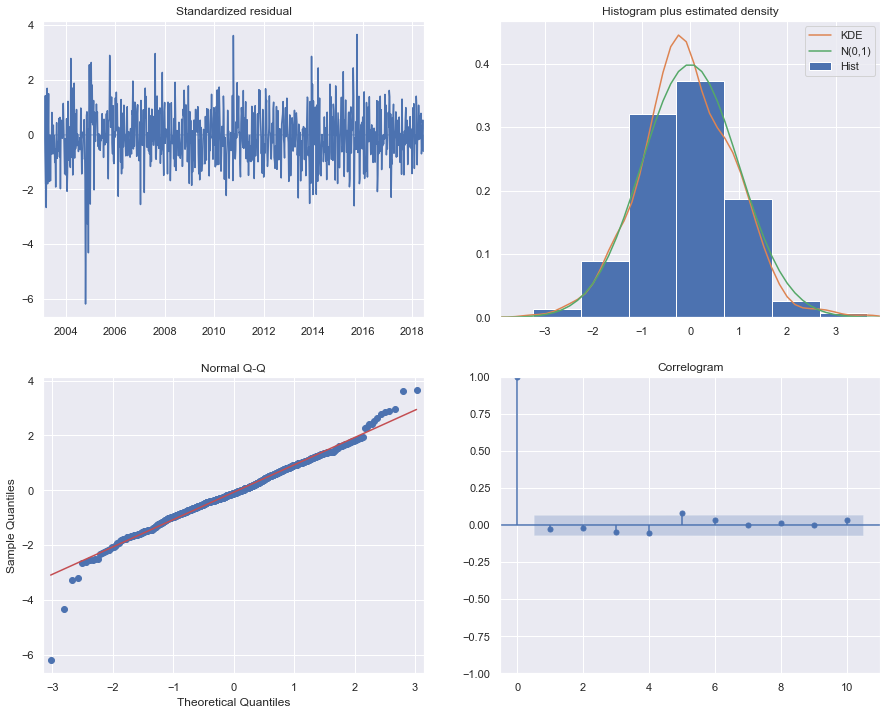

In [39]:
# run diagnostics to check for unusual behaviour
results.plot_diagnostics(figsize=(15, 12))
plt.show()

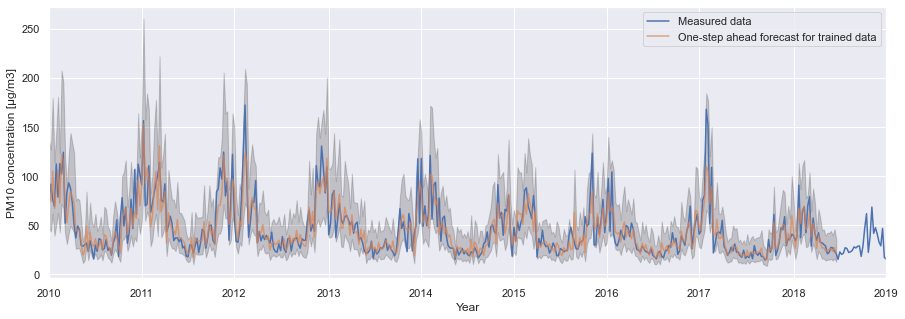

In [40]:
# get predicted values for trained data
pd.plotting.register_matplotlib_converters()
pred = results.get_prediction(start=pd.to_datetime('2010-01-03'), dynamic=False,exog=exog)
pred_ci = pred.conf_int()

plt.figure(figsize=(15,5))
ax = np.exp(y.loc['2010-01-03':]).plot(label='Measured data')
np.exp(pred.predicted_mean).plot(ax=ax, label='One-step ahead forecast for trained data', alpha=.7)

ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('PM10 concentration [µg/m3]')
plt.legend()

plt.show()

In [41]:
# get exog regressor for forecast 
exogf=weather_data.resample('W').mean().loc['2018-7':][['Temperature','Vapor pressure','Rainfall','Wind speed']]

In [42]:
# get forecast 80 weeks ahead in future
pred_uc = results.get_forecast(steps=80,exog=exogf)

# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

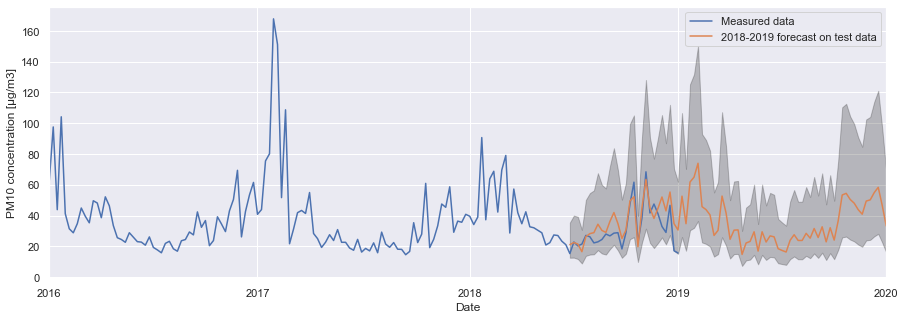

In [43]:
ax = np.exp(y.loc['2016':]).plot(label='Measured data')
np.exp(pred_uc.predicted_mean).plot(ax=ax, label='2018-2019 forecast on test data')
ax.fill_between(pred_ci.index,
                np.exp(pred_ci.iloc[:, 0]),
                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PM10 concentration [µg/m3]')

plt.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error

y_true=y.loc['2018-07-01':'2018-12-30']
y_hat=pred_uc.predicted_mean.loc[:'2018-12-30']
print('Multivariate SARIMAX RMSE is {:.2f}'.format(mean_squared_error(np.exp(y_test),np.exp(y_hat),squared=False)))

Multivariate SARIMAX RMSE is 8.30


# Multivariate Prhophet

In [45]:
# exog regressors 
exog=weather_data.resample('W').mean().loc['2001':'2018-6'][['Temperature','Vapor pressure','Rainfall','Wind speed']]

In [46]:
# transform data into format that fbprophet accepts
fb_pm10=exog.merge(y_train,on='Time').reset_index().rename(columns={'Time': 'ds', 'MeanPM10': 'y'})

In [47]:
# create model and fit it 
fb_model = Prophet(interval_width=0.95,yearly_seasonality=True)
fb_model.add_regressor('Temperature')
fb_model.add_regressor('Wind speed')
fb_model.add_regressor('Vapor pressure')
fb_model.add_regressor('Rainfall')
fb_model.fit(fb_pm10)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
# get forecast 80 weeks ahead in future
exog_future=weather_data.resample('W').mean().loc['2001':'2020-01'][['Temperature','Vapor pressure','Rainfall','Wind speed']].reset_index(drop=True)
future_dates = fb_model.make_future_dataframe(periods=80, freq='W')
'Temperature','Vapor pressure','Rainfall','Wind speed'
future_forecast=future_dates.join(exog_future)


forecast = fb_model.predict(future_forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','Temperature','Vapor pressure','Rainfall','Wind speed']].tail(3)

,ds,yhat,yhat_lower,yhat_upper,Temperature,Vapor pressure,Rainfall,Wind speed
989,2019-12-22,3.819909,3.233644,4.435875,0.079761,-0.059697,-0.004179,0.142890
990,2019-12-29,3.550118,2.930471,4.171180,0.179195,-0.116085,-0.032958,-0.123682
991,2020-01-05,3.346123,2.700848,3.952448,0.189099,-0.181594,0.071643,-0.398188


<Figure size 1080x360 with 0 Axes>

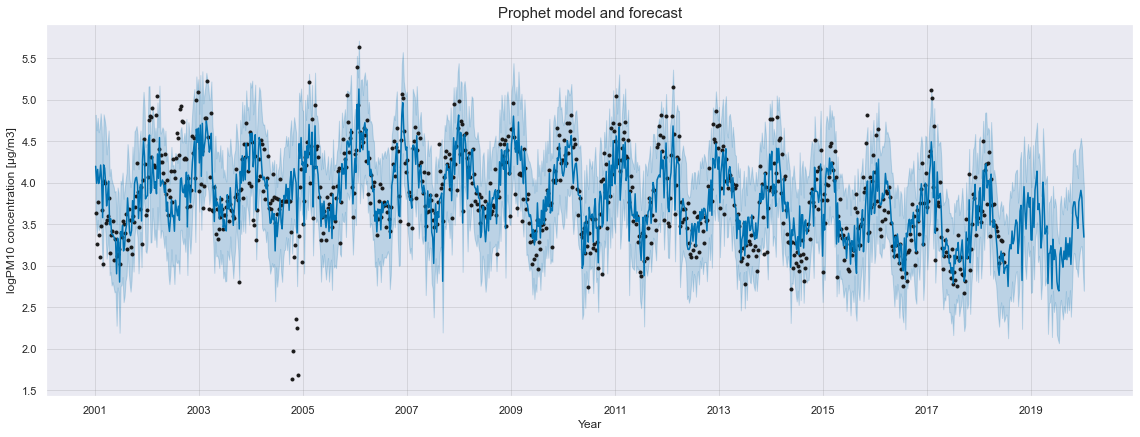

In [49]:
plt.figure()
fb_model.plot(forecast, xlabel = 'Year', ylabel = 'logPM10 concentration [µg/m3]',figsize=(16, 6))
plt.title('Prophet model and forecast',fontsize=15);

Let's use Prophet Model to inspect trends.

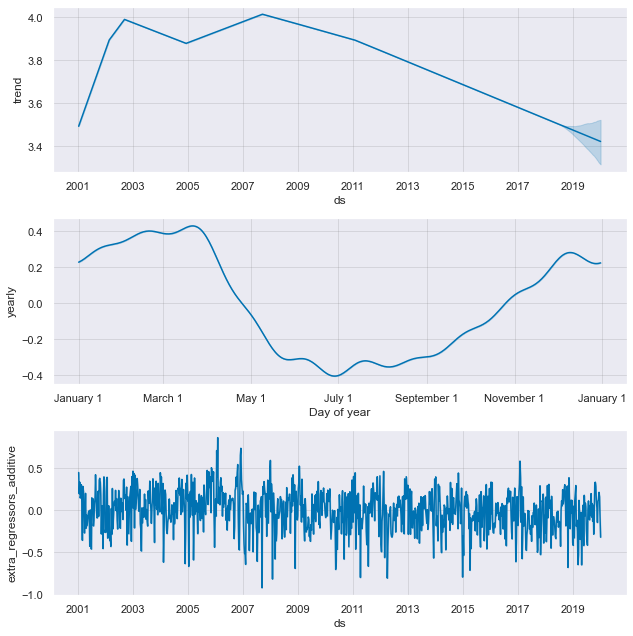

In [50]:
fb_model.plot_components(forecast);

In [51]:
# let's check RMSE for test set
y_hat_fb=forecast.loc[912:938]['yhat']
print('Multivariate Prophet RMSE is {:.2f}'.format(mean_squared_error(np.exp(y_true),np.exp(y_hat_fb),squared=False)))

Multivariate Prophet RMSE is 8.15


# Multivariate models conclusions  and lessons learned
Adding external regressors improved prediction made by both models by around 30 %. On the one hand it might be feasible solution, weather searvices provide long-term forecasts, even few months ahead (for instance https://www.accuweather.com/). On the other hand, adding external regressors means adding extra uncertainty into model and RMSE calculated for multivariate series is not entirely indicative. It took true weather conditions as inputs, not predicted ones. Nevertheless, using multivariate models might be good way to establish possible pm10 levels given changing weather conditions and can provide extra knowledge of what weather change may bring in terms of smog. It enables quicker and wiser reaction and decision making, for both Cracow's inhabitants and the authorities. 

# LSTM and GRU coming soon...

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers